In [72]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# preprocesssing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance


# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 20240417
PATH_TO_FILE = './DT_titanic.csv'

In [73]:
df = pd.read_csv(PATH_TO_FILE)

In [74]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cabin has only 204 out of 991 non-null values - the column is informative, 
we can drop it

In [76]:
df[df['Survived'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [77]:
df.drop(columns='Cabin', inplace=True)

PassengerId, ticket number and Name are irrelevant for prediction
we can drop them too

In [78]:
df.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)

In [79]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [80]:
# split into cat and num features
target_feature = 'Survived'

cat_features = [col for col in df.columns if col not in [target_feature, 'Name'] and pd.api.types.is_object_dtype(df[col])]
num_features = [col for col in df.columns if col not in [target_feature, 'Name']+cat_features]

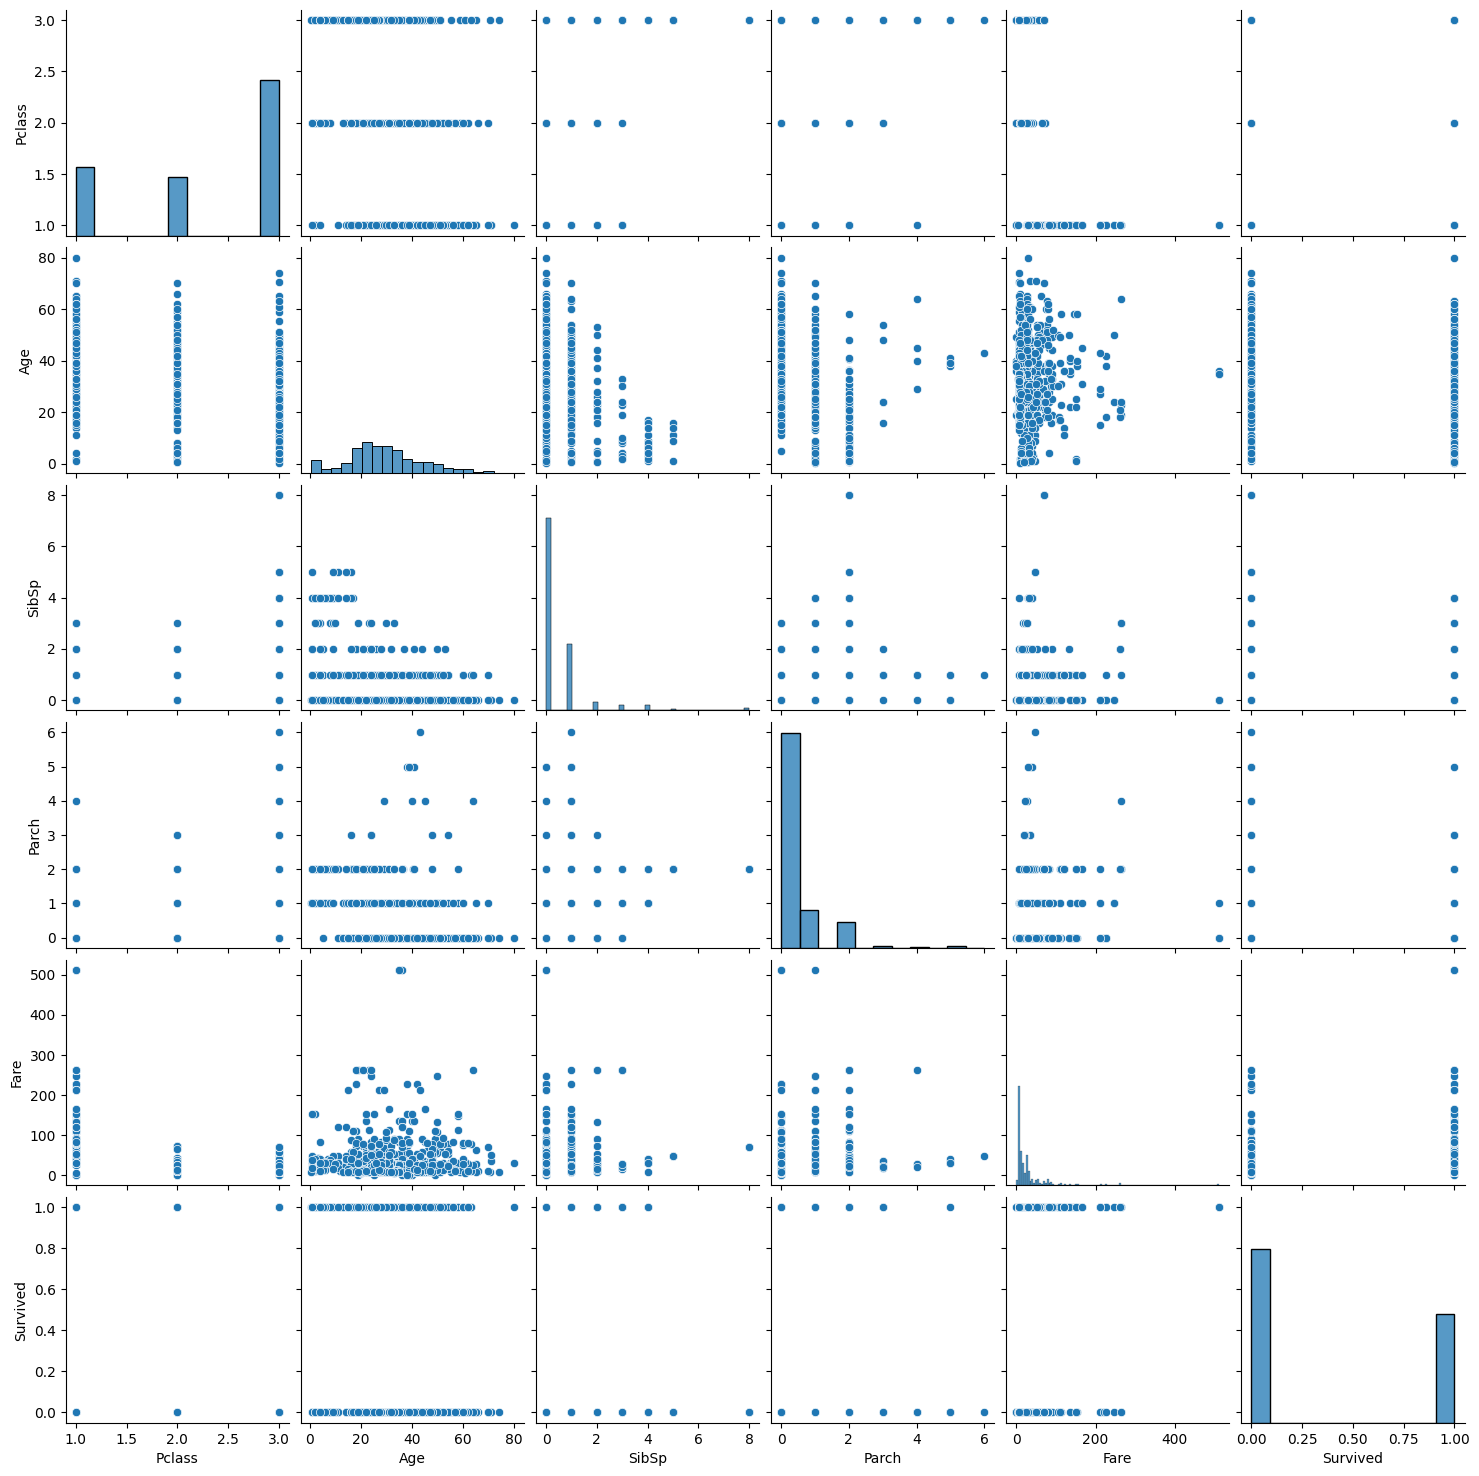

In [81]:
sns.pairplot(df[num_features + ['Survived']])

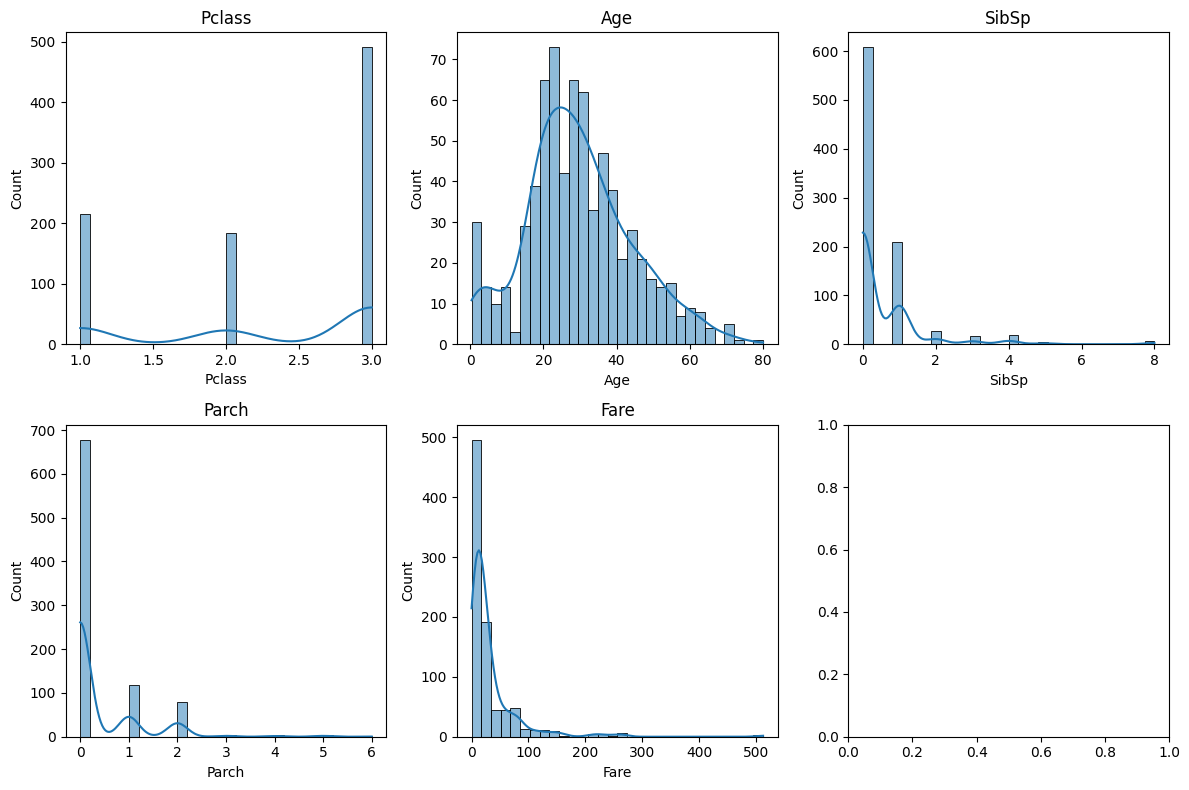

In [82]:
nrows = int(np.ceil(len(num_features) / 3))
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for idx, feature in enumerate(num_features):
    axs[idx//ncols, idx%ncols].set_title(feature)
    sns.histplot(df[feature], kde=True, ax=axs[idx//ncols, idx%ncols], bins=30)
plt.tight_layout()
plt.show()

In [83]:
survived_1st = df[(df['Survived'] == 1) & (df['Pclass'] == 1)].shape[0]
dead_1st = df[(df['Survived'] == 0) & (df['Pclass'] == 1)].shape[0]

survived_2nd = df[(df['Survived'] == 1) & (df['Pclass'] == 2)].shape[0]
dead_2nd = df[(df['Survived'] == 0) & (df['Pclass'] == 2)].shape[0]

survived_3rd = df[(df['Survived'] == 1) & (df['Pclass'] == 3)].shape[0]
dead_3rd = df[(df['Survived'] == 0) & (df['Pclass'] == 3)].shape[0]

print(f'[1st class] -- Survived: {survived_1st}\tDead: {dead_1st}\tServival Rate: {survived_1st/(survived_1st+dead_1st):.3f}')
print(f'[2nd class] -- Survived: {survived_2nd}\tDead: {dead_2nd}\tServival Rate: {survived_2nd/(survived_2nd+dead_2nd):.3f}')
print(f'[3rd class] -- Survived: {survived_3rd}\tDead: {dead_3rd}\tServival Rate: {survived_3rd/(survived_3rd+dead_3rd):.3f}')

[1st class] -- Survived: 136	Dead: 80	Servival Rate: 0.630
[2nd class] -- Survived: 87	Dead: 97	Servival Rate: 0.473
[3rd class] -- Survived: 119	Dead: 372	Servival Rate: 0.242


---
## Understanding the data

In [84]:
df['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [85]:
print(f"Parch > 2 is {df[df['Parch'] > 2]['Parch'].count() / df.size * 100:.2f}%")
print(df[df['Parch'] > 2]['Parch'].count())
#  we can drop them

Parch > 2 is 0.21%
15


In [86]:
parch_indeces = np.array(df.index)[np.argsort(df['Parch'].values)][-15:]
df.drop(index=parch_indeces, inplace=True)

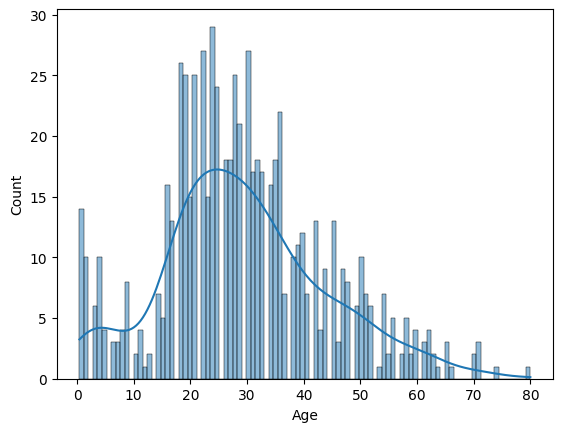

In [87]:
sns.histplot(df['Age'], kde=True, bins=100)
plt.show()

In [88]:
pd.DataFrame(df['Age'].value_counts()).sort_values(by='count')

,count
Age,
74.00,1
20.50,1
14.50,1
34.50,1
0.42,1
...,...
28.00,25
19.00,25
18.00,26


In [89]:
# lets_convert sex into numeric type
sex_encoder = LabelEncoder()
sex = sex_encoder.fit_transform(df["Sex"].values)
print(df["Sex"].iloc[:5].values, sex[:5])
df["Sex"] = sex

['male' 'female' 'female' 'female' 'male'] [1 0 0 0 1]


In [90]:
# embarked has some data gaps, let's feel it with the most common
top_embarked = pd.DataFrame(df['Embarked'].describe()).loc['top']
embarked = df['Embarked'].values
df['Embarked'] = np.where(pd.isna(embarked), top_embarked, embarked)

In [91]:
df[df['Survived'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [92]:
len(df[num_features])

876

In [93]:
# lets incode embarked into one hot encoded vector
onehot_encoder = OneHotEncoder()
encoded_feature = onehot_encoder.fit_transform(df['Embarked'].values.reshape(-1, 1))
encoded_feature_names = onehot_encoder.get_feature_names_out(["Embarked"])
print(encoded_feature_names)
print(df["Embarked"].iloc[0], encoded_feature.toarray()[0])
print(df["Embarked"].iloc[1], encoded_feature.toarray()[1])
print(df["Embarked"].iloc[2], encoded_feature.toarray()[2])

['Embarked_C' 'Embarked_Q' 'Embarked_S']
S [0. 0. 1.]
C [1. 0. 0.]
S [0. 0. 1.]


In [94]:
encoded_df = pd.DataFrame(encoded_feature.toarray(),index=df.index, columns=encoded_feature_names, dtype=int)
encoded_df = pd.concat([df[num_features], encoded_df], axis=1)
encoded_df['Sex'] = df["Sex"]
encoded_df[target_feature] = df[target_feature]
encoded_df.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived
0,3,22.0,1,0,7.2500,0,0,1,1,0
1,1,38.0,1,0,71.2833,1,0,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,1
4,3,35.0,0,0,8.0500,0,0,1,1,0


In [95]:
len(encoded_df)

876

In [96]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      876 non-null    int64  
 1   Age         699 non-null    float64
 2   SibSp       876 non-null    int64  
 3   Parch       876 non-null    int64  
 4   Fare        876 non-null    float64
 5   Embarked_C  876 non-null    int64  
 6   Embarked_Q  876 non-null    int64  
 7   Embarked_S  876 non-null    int64  
 8   Sex         876 non-null    int64  
 9   Survived    876 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 75.3 KB


In [97]:
encoded_df[encoded_df['Survived'].isna()]

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived


In [98]:
df = encoded_df

In [99]:
df['Sex'][df["Age"].isna()].count()

177

In [100]:
# lets fill in the gaps of age
median = df[~df["Age"].isna()]["Age"].median()
print(f"median = {median}")

vals = df["Age"].values
filled_vec = np.where(np.isnan(vals), median, vals)

df["Age"] = filled_vec

median = 28.0


In [101]:
print(f"between 0 and 14 years: {df[(df['Age'] > 0) & (df['Age'] <= 14)]['Age'].count()}")
print(f"between 14 and 21 years: {df[(df['Age'] > 14) & (df['Age'] <= 21)]['Age'].count()}")
print(f"between 21 and 30 years: {df[(df['Age'] > 21) & (df['Age'] <= 30)]['Age'].count()}")
print(f"between 30 and 50 years: {df[(df['Age'] > 30) & (df['Age'] <= 50)]['Age'].count()}")
print(f"between 50 and 70 years: {df[(df['Age'] > 50) & (df['Age'] < 70)]['Age'].count()}")
print(f"more than 70 years: {df[df['Age'] >= 70]['Age'].count()}")

between 0 and 14 years: 77
between 14 and 21 years: 126
between 21 and 30 years: 379
between 30 and 50 years: 232
between 50 and 70 years: 55
more than 70 years: 7


сгруппируем по возрасту

In [102]:
vec = (df['Age'] > 0) & (df['Age'] <= 14)

In [103]:
# let's drop people with age more than 70
# age_indeces = np.array(df.index)[np.argsort(df["Age"].values)][-7:]
# df.drop(index=age_indeces, inplace=True)

In [104]:
df[df["Age"] >= 70]

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,Survived
96,1,71.0,0,0,34.6542,1,0,0,1,0
116,3,70.5,0,0,7.7500,0,1,0,1,0
493,1,71.0,0,0,49.5042,1,0,0,1,0
630,1,80.0,0,0,30.0000,0,0,1,1,1
672,2,70.0,0,0,10.5000,0,0,1,1,0
745,1,70.0,1,1,71.0000,0,0,1,1,0
851,3,74.0,0,0,7.7750,0,0,1,1,0


In [105]:
features = [col for col in df.columns if col != target_feature]

In [106]:
X, y = df[features].values, df[target_feature].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

---
# Decision Tree

<b> подбор параметров выполним посредством K-fold cross validation </b> <br>
Обучающая выборка разбивается на к подвыборок, <br>
последовательно убираем одну из подвыборок с возвращением для валидации <br>
оставшиеся подвборки конкатенируются и отправляются для обучения модели <br>
в итоге получаем к моделей и к предсказаний на к подвыборках <br>
точность с каждого предсказания усредняется и выбираем такие параметры, <br>
при которых средняя точность максимальна 

In [107]:
def get_best_dt_params(X_train, y_train, k_folds=5):
    best_accuracy = -1

    best_params = {}

    depths = [i for i in range(5, len(features)*2, 2)]
    criterions = ['gini', 'entropy']
    min_samples_splits = [i for i in range(2, 20, 2)]
    min_samples_leaves = [i for i in range(1, 20, 2)]
    max_features_items = ['sqrt', 'log2', None]
    max_leaf_nodes_items = [i for i in range(5, 70, 10)]

    kf = KFold(n_splits=k_folds, random_state=RANDOM_SEED, shuffle=True)

    for depth in depths:
        for criterion in criterions:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leaves:
                    for max_features in max_features_items:
                        for max_leaf_nodes in max_leaf_nodes_items + [None]:
                            avg_accuracy = 0

                            for i ,(train_split, test_split) in enumerate(kf.split(X_train)):
                                dt = DecisionTreeClassifier(max_depth=depth,
                                                            criterion=criterion,
                                                            min_samples_split=min_samples_split,
                                                            min_samples_leaf=min_samples_leaf,
                                                            max_features=max_features,
                                                            max_leaf_nodes=max_leaf_nodes,
                                                            random_state=RANDOM_SEED)

                                dt.fit(X_train[train_split], y_train[train_split])
                                avg_accuracy += accuracy_score(y_train[test_split], 
                                                            dt.predict(X_train[test_split]))
                            
                            if avg_accuracy / k_folds > best_accuracy:
                                best_accuracy = avg_accuracy / k_folds
                                best_params = {'max_depth': depth,
                                                'criterion': criterion,
                                                'min_samples_split': min_samples_split,
                                                'min_samples_leaf': min_samples_leaf,
                                                'max_features': max_features,
                                                'max_leaf_nodes': max_leaf_nodes,
                                                'random_state': RANDOM_SEED}
    print(f'best_accuracy: {best_accuracy}')
    return best_params

In [108]:
# best_params = get_best_dt_params(X_train, y_train)
# best_params

best_accuracy: 0.8285714285714285


{'max_depth': 9,
 'criterion': 'gini',
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_leaf_nodes': 35,
 'random_state': 20240417}

In [127]:
# saved from grid search
best_params = {'max_depth': 9,
                'criterion': 'gini',
                'min_samples_split': 6,
                'min_samples_leaf': 1,
                'max_features': None,
                'max_leaf_nodes': 35,
                'random_state': 20240417}

In [123]:
dt = DecisionTreeClassifier(**best_params)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=35, min_samples_split=6,
                       random_state=20240417)

In [124]:
print(f'accuracy: {accuracy_score(y_train, dt.predict(X_train))}')
print(f'accuracy: {accuracy_score(y_test, dt.predict(X_test))}')

accuracy: 0.9
accuracy: 0.8352272727272727


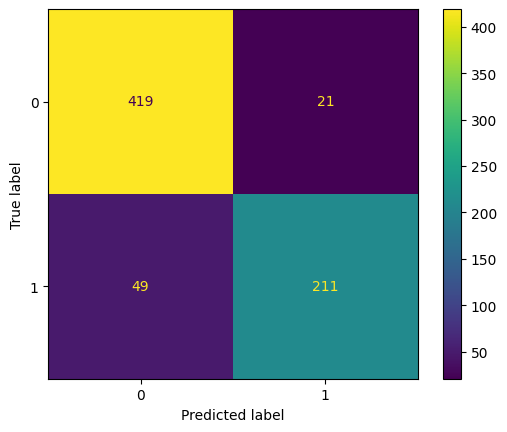

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       440
           1       0.91      0.81      0.86       260

    accuracy                           0.90       700
   macro avg       0.90      0.88      0.89       700
weighted avg       0.90      0.90      0.90       700



In [125]:
prediction = dt.predict(X_train)
cm = confusion_matrix(y_train, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_train, prediction))

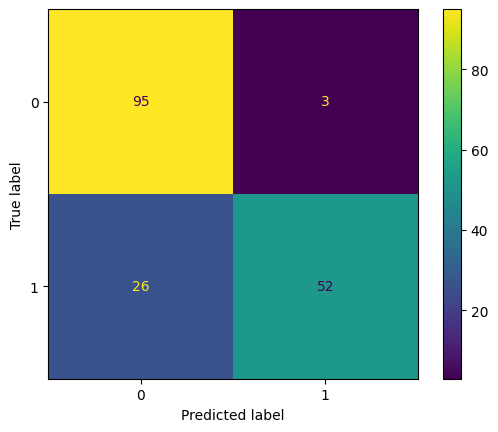

              precision    recall  f1-score   support

           0       0.79      0.97      0.87        98
           1       0.95      0.67      0.78        78

    accuracy                           0.84       176
   macro avg       0.87      0.82      0.82       176
weighted avg       0.86      0.84      0.83       176



In [126]:
prediction = dt.predict(X_test)
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test, prediction))

Возможно нам важно точно предсказать, кто не выживет, <br>
если мы страховая компания, то для таких людей страховка обойдется дороже, <br>
или не будет оказана таковая услуга <br>
Для этого обратим внимание на метрику recall для класса 0

In [114]:
# features in desc order of their importance rate
feature_importances = dt.feature_importances_
print(np.array(features)[np.argsort(feature_importances)])

['Embarked_C' 'Embarked_Q' 'Embarked_S' 'Parch' 'SibSp' 'Pclass' 'Age'
 'Fare' 'Sex']


---
cluster by age

In [115]:
print(f"between 0 and 14 years: {df[(df['Age'] > 0) & (df['Age'] <= 14)]['Age'].count()}")
print(f"between 14 and 21 years: {df[(df['Age'] > 14) & (df['Age'] <= 21)]['Age'].count()}")
print(f"between 21 and 30 years: {df[(df['Age'] > 21) & (df['Age'] <= 30)]['Age'].count()}")
print(f"between 30 and 50 years: {df[(df['Age'] > 30) & (df['Age'] <= 50)]['Age'].count()}")
print(f"between 50 and 70 years: {df[(df['Age'] > 50) & (df['Age'] < 70)]['Age'].count()}")
print(f"more than 70 years: {df[df['Age'] >= 70]['Age'].count()}")

between 0 and 14 years: 77
between 14 and 21 years: 126
between 21 and 30 years: 379
between 30 and 50 years: 232
between 50 and 70 years: 55
more than 70 years: 7


In [116]:
groups = ['child', 'teen', 'young', 'mature', 'old']

sub_df = df.copy()

ages = df["Age"].values

child = np.where((df['Age'] > 0) & (df['Age'] <= 14), 1, 0)
teen = np.where((df['Age'] > 14) & (df['Age'] <= 21), 1, 0)
young = np.where((df['Age'] > 21) & (df['Age'] <= 30), 1, 0)
mature = np.where((df['Age'] > 30) & (df['Age'] <= 50), 1, 0)
old = np.where(df['Age'] > 30, 1, 0)

group_values = [child, teen, young, mature, old]

sub_df = sub_df.drop(columns='Age')

for group, values in zip(groups, group_values):
    sub_df[group] = values

In [117]:
features_sub = [col for col in sub_df.columns if col != target_feature]
sub_df = sub_df[features_sub+[target_feature]]
sub_df.head()

,Pclass,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex,child,teen,young,mature,old,Survived
0,3,1,0,7.2500,0,0,1,1,0,0,1,0,0,0
1,1,1,0,71.2833,1,0,0,0,0,0,0,1,1,1
2,3,0,0,7.9250,0,0,1,0,0,0,1,0,0,1
3,1,1,0,53.1000,0,0,1,0,0,0,0,1,1,1
4,3,0,0,8.0500,0,0,1,1,0,0,0,1,1,0


In [147]:
X_sub, y_sub = sub_df[features_sub].values, sub_df[target_feature].values

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, 
                                                                    test_size=0.2,
                                                                    random_state=RANDOM_SEED)

In [148]:
# best_params_sub = get_best_dt_params(X_train_sub, y_train_sub)
# best_params_sub

best_accuracy: 0.8314285714285713


{'max_depth': 5,
 'criterion': 'entropy',
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_leaf_nodes': 15,
 'random_state': 20240417}

In [166]:
best_params_sub = {'max_depth': 5,
                    'criterion': 'entropy',
                    'min_samples_split': 10,
                    'min_samples_leaf': 1,
                    'max_features': None,
                    'max_leaf_nodes': 15,
                    'random_state': 20240417}


In [167]:
dt_sub = DecisionTreeClassifier(**best_params_sub)

dt_sub.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=15,
                       min_samples_split=10, random_state=20240417)

In [168]:
print(f'accuracy: {accuracy_score(y_train_sub, dt_sub.predict(X_train_sub))}')
print(f'accuracy: {accuracy_score(y_test_sub, dt_sub.predict(X_test_sub))}')

accuracy: 0.8557142857142858
accuracy: 0.8068181818181818


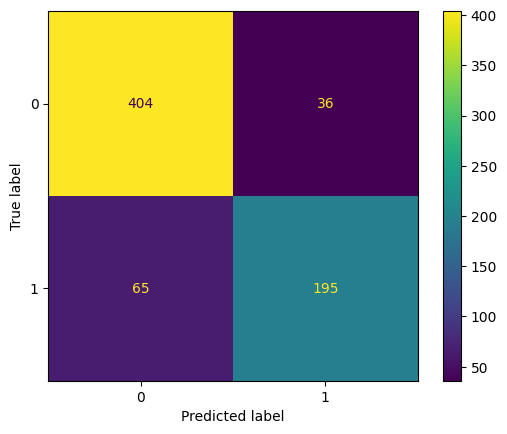

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       440
           1       0.84      0.75      0.79       260

    accuracy                           0.86       700
   macro avg       0.85      0.83      0.84       700
weighted avg       0.85      0.86      0.85       700



In [169]:
prediction = dt_sub.predict(X_train_sub)
cm = confusion_matrix(y_train_sub, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_train_sub, prediction))

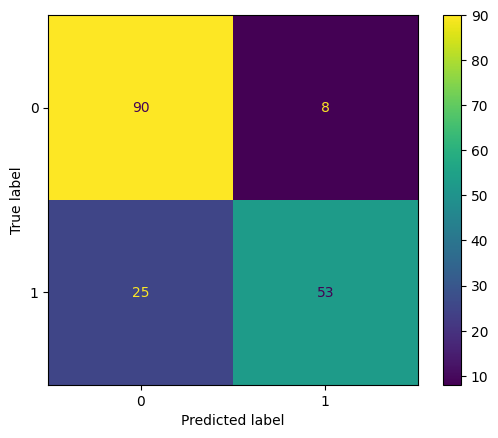

              precision    recall  f1-score   support

           0       0.78      0.92      0.85        98
           1       0.87      0.68      0.76        78

    accuracy                           0.81       176
   macro avg       0.83      0.80      0.80       176
weighted avg       0.82      0.81      0.81       176



In [152]:
prediction = dt_sub.predict(X_test_sub)
cm = confusion_matrix(y_test_sub, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test_sub, prediction))

Из результатов классификации видно, что кластеризация по возрасту не дает улучшение <br>
качества предсказания по метрике "Accuracy", не ухудшая "Recall". Возможно дальнейшее scrutiny <br>
в этом направлении поможет улучшить точность классификации.

In [55]:
# features in desc order of their importance rate
feature_importances = dt_sub.feature_importances_
print(np.array(features_sub)[np.argsort(feature_importances)])

['Embarked_C' 'Embarked_Q' 'Embarked_S' 'teen' 'young' 'old' 'mature'
 'Parch' 'child' 'SibSp' 'Pclass' 'Fare' 'Sex']


--- 
# Random Forest

In [175]:
def get_random_forest_best_params(X_train, y_train, k_folds=5):
    k_folds = 5
    best_accuracy = -1

    best_params = {}

    n_estimators =  [10, 100]# [i for i in range(10, 121, 10)]
    depths = [i for i in range(5, len(features)*2, 2)]
    criterions = ['gini', 'entropy']
    min_samples_splits = [i for i in range(2, 20, 2)]
    min_samples_leaves = [i for i in range(1, 20, 2)]
    max_features_items = ['sqrt', 'log2', None]
    max_leaf_nodes_items = [i for i in range(5, 70, 10)]

    kf = KFold(n_splits=k_folds, random_state=RANDOM_SEED, shuffle=True)

    for estimator in n_estimators:
        for depth in depths:
            for criterion in criterions:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leaves:
                        for max_features in max_features_items:
                            for max_leaf_nodes in max_leaf_nodes_items + [None]:
                                avg_accuracy = 0

                                for i ,(train_split, test_split) in enumerate(kf.split(X_train)):
                                    rf = RandomForestClassifier(max_depth=depth,
                                                                n_estimators=estimator,
                                                                criterion=criterion,
                                                                min_samples_split=min_samples_split,
                                                                min_samples_leaf=min_samples_leaf,
                                                                max_features=max_features,
                                                                max_leaf_nodes=max_leaf_nodes,
                                                                random_state=RANDOM_SEED)

                                    rf.fit(X_train[train_split], y_train[train_split])
                                    avg_accuracy += accuracy_score(y_train[test_split], 
                                                                dt.predict(X_train[test_split]))
                                
                                if avg_accuracy / k_folds > best_accuracy:
                                    best_accuracy = avg_accuracy / k_folds
                                    best_params = {'max_depth': depth,
                                                    'n_estimators': estimator,
                                                    'criterion': criterion,
                                                    'min_samples_split': min_samples_split,
                                                    'min_samples_leaf': min_samples_leaf,
                                                    'max_features': max_features,
                                                    'max_leaf_nodes': max_leaf_nodes,
                                                    'random_state': RANDOM_SEED}
    print(f"best accuracy: {best_accuracy}")
    return best_params

In [57]:
# best_params = get_random_forest_best_params()
# best_params

In [153]:
best_params = {'n_estimators': 100,
                'max_depth': 15,
                'criterion': 'gini',
                'min_samples_split': 6,
                'min_samples_leaf': 1,
                'max_features': None,
                'max_leaf_nodes': 35,
                'random_state': 20240417}

In [154]:
best_params

{'n_estimators': 100,
 'max_depth': 15,
 'criterion': 'gini',
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_leaf_nodes': 35,
 'random_state': 20240417}

In [155]:
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=None, max_leaf_nodes=35,
                       min_samples_split=6, random_state=20240417)

In [156]:
print(f'accuracy: {accuracy_score(y_train, rf.predict(X_train))}')
print(f'accuracy: {accuracy_score(y_test, rf.predict(X_test))}')

accuracy: 0.9171428571428571
accuracy: 0.8238636363636364


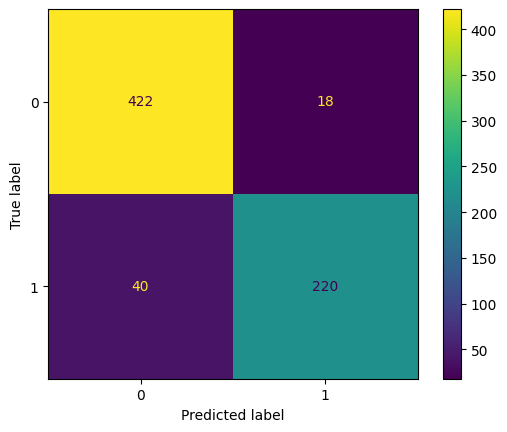

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       440
           1       0.92      0.85      0.88       260

    accuracy                           0.92       700
   macro avg       0.92      0.90      0.91       700
weighted avg       0.92      0.92      0.92       700



In [157]:
prediction = rf.predict(X_train)
cm = confusion_matrix(y_train, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_train, prediction))

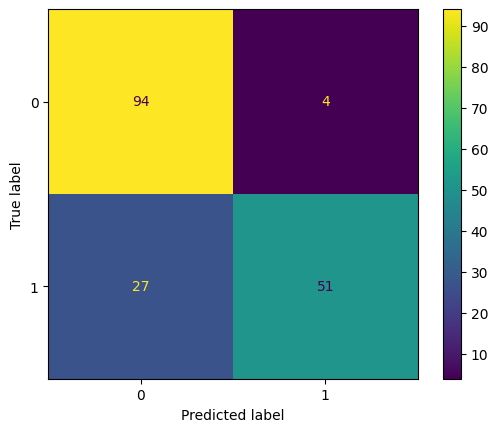

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        98
           1       0.93      0.65      0.77        78

    accuracy                           0.82       176
   macro avg       0.85      0.81      0.81       176
weighted avg       0.84      0.82      0.82       176



In [159]:
prediction = rf.predict(X_test)
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test, prediction))

In [64]:
# features in desc order of their importance rate
feature_importances = rf.feature_importances_
print(np.array(features)[np.argsort(feature_importances)])

['Embarked_Q' 'Embarked_C' 'Parch' 'Embarked_S' 'SibSp' 'Pclass' 'Age'
 'Fare' 'Sex']


---
with age clustering

In [65]:
# best_params = get_random_forest_best_params(X_train_sub, y_train_sub)
# best_params_sub

In [170]:
best_params_sub = {'n_estimators': 100,
                    'max_depth': 11,
                    'criterion': 'gini',
                    'min_samples_split': 6,
                    'min_samples_leaf': 1,
                    'max_features': None,
                    'max_leaf_nodes': 35,
                    'random_state': 20240417}

In [171]:
rf_sub = RandomForestClassifier(**best_params_sub)
rf_sub.fit(X_train_sub, y_train_sub)

RandomForestClassifier(max_depth=11, max_features=None, max_leaf_nodes=35,
                       min_samples_split=6, random_state=20240417)

In [172]:
print(f'accuracy: {accuracy_score(y_train_sub, rf_sub.predict(X_train_sub))}')
print(f'accuracy: {accuracy_score(y_test_sub, rf_sub.predict(X_test_sub))}')

accuracy: 0.9128571428571428
accuracy: 0.8238636363636364


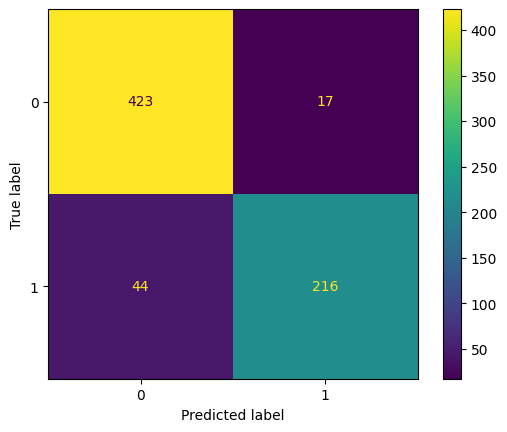

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       440
           1       0.93      0.83      0.88       260

    accuracy                           0.91       700
   macro avg       0.92      0.90      0.90       700
weighted avg       0.91      0.91      0.91       700



In [173]:
prediction = rf_sub.predict(X_train_sub)
cm = confusion_matrix(y_train_sub, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_train_sub, prediction))

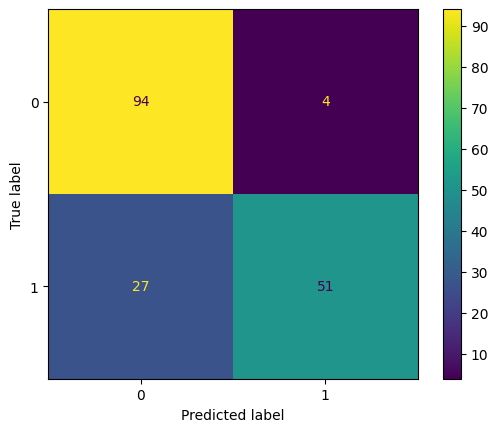

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        98
           1       0.93      0.65      0.77        78

    accuracy                           0.82       176
   macro avg       0.85      0.81      0.81       176
weighted avg       0.84      0.82      0.82       176



In [174]:
prediction = rf_sub.predict(X_test_sub)
cm = confusion_matrix(y_test_sub, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test_sub, prediction))

In [165]:
# features in desc order of their importance rate
feature_importances = rf_sub.feature_importances_
print(np.array(features_sub)[np.argsort(feature_importances)])

['Embarked_Q' 'Embarked_C' 'old' 'teen' 'young' 'Embarked_S' 'Parch'
 'mature' 'child' 'SibSp' 'Pclass' 'Fare' 'Sex']
